In [1]:
import sys
import json
from itertools import count
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.datasets import make_moons
from sklearn.cluster import spectral_clustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm

from model import LocalDictionary
from utils import *

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)

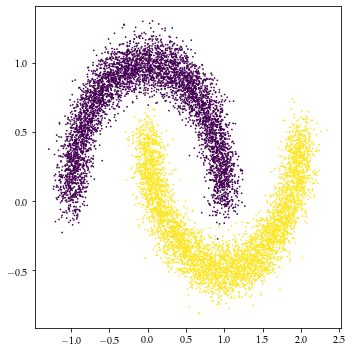

In [3]:
dataset = "moons"

y_train, l_train = make_moons(10000)
y_train = torch.tensor(y_train).float()
y_train += 0.1 * torch.randn(y_train.shape)
y_test, l_test = y_train, l_train

plt.figure(figsize=(5,5))
plt.scatter(*y_test.T, c=l_test, s=0.5)
plt.tight_layout()
plt.savefig("figs/moons/input.png", dpi=300)
plt.show()

def show(path):
    net.eval()
    x_hat_test = net.encode(y_test)
    y_hat_test = net.decode(x_hat_test)
    plt.figure(figsize=(5,5))
    plt.scatter(*y_test.T, c="gray", s=0.5)
    plt.scatter(*y_hat_test.clone().detach().T, c=l_test, s=5.0)
    plt.scatter(*net.W.data.T, c="red")
    if path:
        plt.tight_layout()
        plt.savefig(path, dpi=300)
    plt.show()

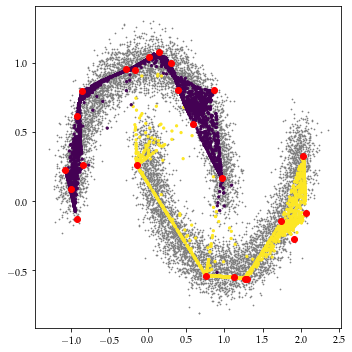

In [4]:
penalty = 5.0
net = LocalDictionary(15, 2, 24, penalty)
optimizer = optim.Adam(net.parameters())
criterion = LocalDictionaryLoss(penalty)

with torch.no_grad():
    net.W.data = y_train[torch.randperm(y_train.shape[0])][:net.hidden_size]
    net.step.fill_((net.W.data.svd()[1][0] ** -2).item())

show(f"figs/{dataset}/0.png")

 24%|██▍       | 244/1000 [00:03<00:09, 76.64it/s]

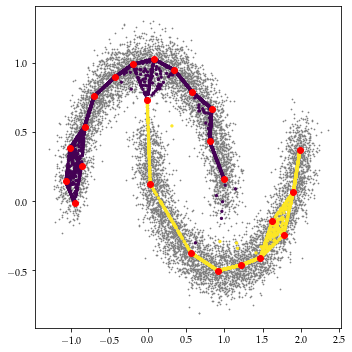

 49%|████▉     | 492/1000 [00:07<00:06, 76.01it/s]

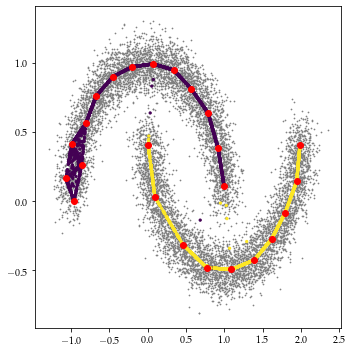

 75%|███████▍  | 748/1000 [00:11<00:03, 76.03it/s]

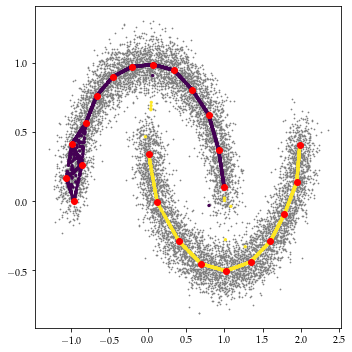

100%|█████████▉| 996/1000 [00:15<00:00, 75.20it/s]

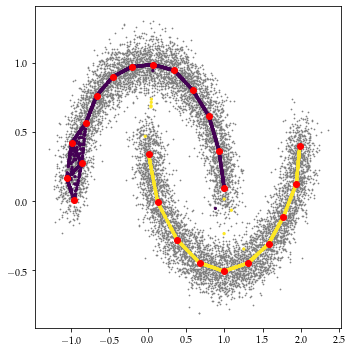

100%|██████████| 1000/1000 [00:16<00:00, 61.57it/s]


In [5]:
epochs = 1000
device = "cuda:0"
net = net.to(device)
y_train = y_train.to(device)
for epoch in tqdm(range(epochs)):
    net.train()
    optimizer.zero_grad()
    x_hat_train = net.encode(y_train)
    loss = criterion(net.W, y_train, x_hat_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) * 4 % epochs == 0:
        net = net.cpu()
        y_train = y_train.cpu()
        show(f"figs/{dataset}/{epoch+1}.png")
        net = net.to(device)
        y_train = y_train.to(device)
net = net.cpu()
y_train = y_train.cpu()

In [6]:
print("mean sparsity =", (x_hat_train.abs() > 0).float().sum(dim=1).mean().item())
print("median sparsity =", (x_hat_train.abs() > 0).float().sum(dim=1).median().item())

# sanity check
print("sum of coefficients =", x_hat_train.abs().sum(dim=1).mean().item())

mean sparsity = 1.2753000259399414
median sparsity = 1.0
sum of coefficients = 1.0


/home/ptankala/.conda/envs/pranay/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


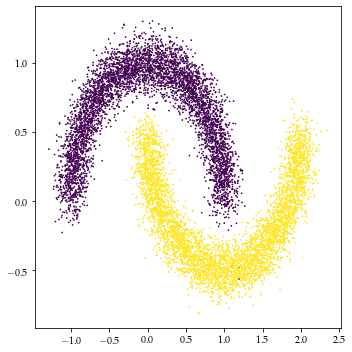

accuracy = 0.9981


In [7]:
net.num_layers.fill_(15)

n = y_train.shape[0]
m = net.hidden_size
sim = np.zeros((n + m, n + m))
for i in range(n):
    for j in range(m):
        sim[i, j] = x_hat_train[i, j]
        sim[j, i] = x_hat_train[i, j]
l_hat_train = spectral_clustering(sim, n_clusters=2)

plt.figure(figsize=(5,5))
plt.scatter(*y_train.T, c=l_hat_train[:y_train.shape[0]], s=0.5)
plt.tight_layout()
plt.savefig(f"figs/{dataset}/preds.png", dpi=300)
plt.show()
print("accuracy =", acc(l_train, torch.tensor(l_hat_train[:y_train.shape[0]]))[0])

In [8]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", n_neighbors=1000)
l_hat_train_simple = sc.fit_predict(y_train)
print(acc(l_train, l_hat_train_simple)[0])

0.9113
